In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'


/tmp/ipykernel_390/3363248783.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load output:

In [9]:
in_dir = '/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d/'
output_files = []
for root, dirs, files in os.walk(in_dir, topdown=False):
    for name in files:
        output_files.append(os.path.join(root, name))
ssps = ['ssp245','ssp585']
for s,ssp in enumerate(ssps):
    ssp_ds = xr.open_mfdataset(fnmatch.filter(output_files,'*'+ssp+'*'),concat_dim='source_id',combine='nested',coords='minimal',compat='override',join='outer')
    ssp_ds = ssp_ds.assign_coords({'source_id':[s.split('/')[8] for s in fnmatch.filter(output_files,'*'+ssp+'*')]})
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp',coords='minimal',compat='override',join='outer')
ds = ds.assign_coords({'ssp':ssps})

#04-05-23
compl = ds['complete_window'].copy(deep=True)

In [15]:
in_dir = '/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref2000/'
output_files = []
for root, dirs, files in os.walk(in_dir, topdown=False):
    for name in files:
        output_files.append(os.path.join(root, name))
ssps = ['ssp245','ssp585']
for s,ssp in enumerate(ssps):
    ssp_ds = xr.open_mfdataset(fnmatch.filter(output_files,'*'+ssp+'*'),concat_dim='source_id',combine='nested',coords='minimal',compat='override',join='outer')
    ssp_ds = ssp_ds.assign_coords({'source_id':[s.split('/')[8] for s in fnmatch.filter(output_files,'*'+ssp+'*')]})
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp',coords='minimal',compat='override',join='outer')
ds = ds.assign_coords({'ssp':ssps})
#ds['complete_window'] = compl

ValueError: cannot reindex or align along dimension 'source_id' because the (pandas) index has duplicate values

In [8]:
ds

<xarray.Dataset>
Dimensions:             (ssp: 2, source_id: 13, member_id: 67,
                         extreme_variate: 3, window: 6, latitude: 34,
                         longitude: 51, statistic: 2, estimator: 2,
                         quantile: 10, month: 12)
Coordinates:
  * member_id           (member_id) object 'r101i1p1f1' ... 'r7i1p1f1'
  * longitude           (longitude) int64 -30 -29 -28 -27 -26 ... 16 17 18 19 20
  * latitude            (latitude) int64 35 36 37 38 39 40 ... 63 64 65 66 67 68
  * window              (window) int64 1980 2000 2020 2040 2060 2080
  * quantile            (quantile) float64 0.9 0.91 0.92 0.93 ... 0.97 0.98 0.99
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * extreme_variate     (extreme_variate) object 'sfcWind' 'pr' 'both'
  * statistic           (statistic) object 'coef' 'p'
  * estimator           (estimator) object 'cfg' '.95'
  * source_id           (source_id) <U15 'CESM2' 'CESM2-WACCM' ... 'TaiESM1'
    height              float64 10.0
  * ssp                 (ssp) <U6 'ssp245' 'ssp585'
Data variables:
    ktau                (ssp, source_id, member_id, extreme_variate, window, latitude, longitude, statistic) float64 dask.array<chunksize=(1, 1, 67, 3, 6, 34, 51, 2), meta=np.ndarray>
    utdc                (ssp, source_id, member_id, estimator, window, latitude, longitude, statistic) float64 dask.array<chunksize=(1, 1, 67, 2, 6, 34, 51, 2), meta=np.ndarray>
    complete_window     (ssp, source_id, member_id, window, latitude, longitude) float64 dask.array<chunksize=(1, 1, 67, 6, 34, 51), meta=np.ndarray>
    sfcWind_thresholds  (ssp, source_id, member_id, quantile, window, latitude, longitude) float64 dask.array<chunksize=(1, 1, 67, 10, 6, 34, 51), meta=np.ndarray>
    pr_thresholds       (ssp, source_id, member_id, quantile, window, latitude, longitude) float64 dask.array<chunksize=(1, 1, 67, 10, 6, 34, 51), meta=np.ndarray>
Attributes: (12/69)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_dataset_key:           CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1...
    original_key:                     CMCC-ESM2.gn.historical.day.r1i1p1f1
    regrid_method:                    bilinear
    window_length:                    40
    declustering:                     Rolling window of 1 days
    allowed_lag:                      0

In [10]:
ds = ds.drop_vars(['num_co_occurring','num_pr_peaks','num_sfcWind_peaks'])

Compute slopes change/window:

In [11]:
complete = ds.complete_window.sel(window=slice(1850,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1850,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds = ds.sel(window=slice(1980,2100))
timesteps = xr.DataArray(data=np.arange(len(ds.window)),dims=['window'],coords=dict(window=ds.window))
'''
ds['ktau_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.ktau,timesteps,dim='window')*ds.ktau.std(dim='window')/timesteps.std(dim='window')
ds['utdc_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.utdc,timesteps,dim='window')*ds.utdc.std(dim='window')/timesteps.std(dim='window')
ds['num_co_occurring_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.num_co_occurring,timesteps,dim='window')*ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
'''
#ds.load()

"\nds['ktau_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.ktau,timesteps,dim='window')*ds.ktau.std(dim='window')/timesteps.std(dim='window')\nds['utdc_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.utdc,timesteps,dim='window')*ds.utdc.std(dim='window')/timesteps.std(dim='window')\nds['num_co_occurring_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.num_co_occurring,timesteps,dim='window')*ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')\n"

In [12]:
ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','longitude','latitude']))

In [13]:
ds_intersect.load()

<xarray.Dataset>
Dimensions:             (ssp: 2, source_id: 13, member_id: 67,
                         extreme_variate: 3, window: 6, latitude: 34,
                         longitude: 51, statistic: 2, estimator: 2,
                         quantile: 10, month: 12)
Coordinates:
  * member_id           (member_id) object 'r101i1p1f1' ... 'r7i1p1f1'
  * longitude           (longitude) int64 -30 -29 -28 -27 -26 ... 16 17 18 19 20
  * latitude            (latitude) int64 35 36 37 38 39 40 ... 63 64 65 66 67 68
  * window              (window) int64 1980 2000 2020 2040 2060 2080
  * quantile            (quantile) float64 0.9 0.91 0.92 0.93 ... 0.97 0.98 0.99
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * extreme_variate     (extreme_variate) object 'sfcWind' 'pr' 'both'
  * statistic           (statistic) object 'coef' 'p'
  * estimator           (estimator) object 'cfg' '.95'
  * source_id           (source_id) <U15 'CESM2' 'CESM2-WACCM' ... 'TaiESM1'
    height              float64 10.0
  * ssp                 (ssp) <U6 'ssp245' 'ssp585'
Data variables:
    ktau                (ssp, source_id, member_id, extreme_variate, window, latitude, longitude, statistic) float64 ...
    utdc                (ssp, source_id, member_id, estimator, window, latitude, longitude, statistic) float64 ...
    complete_window     (ssp, source_id, member_id, window, latitude, longitude) float64 ...
    sfcWind_thresholds  (ssp, source_id, member_id, quantile, window, latitude, longitude) float64 ...
    pr_thresholds       (ssp, source_id, member_id, quantile, window, latitude, longitude) float64 ...
Attributes: (12/69)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_dataset_key:           CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1...
    original_key:                     CMCC-ESM2.gn.historical.day.r1i1p1f1
    regrid_method:                    bilinear
    window_length:                    40
    declustering:                     Rolling window of 1 days
    allowed_lag:                      0

**Ensemble mean Kendall's Tau:**

Using intersection of ssp's for comparison between scenarios:

**Ensemble mean's UTDC**

Intersection

Using all data per ssp:

AttributeError: 'Dataset' object has no attribute 'sfcWind_thresholds_djf'

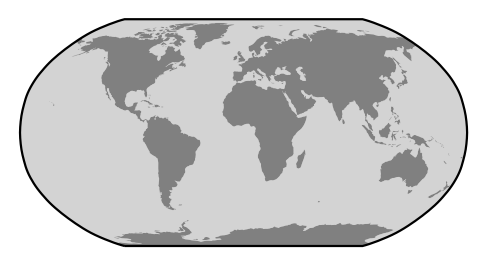

In [14]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(ssp_ds_diff.sfcWind_thresholds_djf.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-2,vmax=2,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% [m/s]')
        ax.set_title('')
    if s==0:
        ax.set_title('d djf 98%')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(ssp_ds_diff.sfcWind_thresholds_annual.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-2,vmax=2,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('d annual 98%')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% [m/s]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=((ssp_ds_diff.sfcWind_thresholds_djf.isel(quantile=8)-ssp_ds_diff.sfcWind_thresholds_annual.isel(quantile=8)).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-2,vmax=2,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$d98% [m/s]')
        ax.set_title('')
    if s==0:
        ax.set_title('djf d98% minus annual d98%')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    '''
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    '''

In [ ]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(ssp_ds_diff.pr_thresholds_djf.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.01,vmax=.01,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% [mm]')
        ax.set_title('')
    if s==0:
        ax.set_title('d djf 98%')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(((ssp_ds_diff.pr_thresholds_mam.isel(quantile=8)+ssp_ds_diff.pr_thresholds_jja.isel(quantile=8)+ssp_ds_diff.pr_thresholds_son.isel(quantile=8))/3).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.01,vmax=.01,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('d annual 98%')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% [mm]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=((ssp_ds_diff.pr_thresholds_djf.isel(quantile=8)-(ssp_ds_diff.pr_thresholds_mam.isel(quantile=8)+ssp_ds_diff.pr_thresholds_jja.isel(quantile=8)+ssp_ds_diff.pr_thresholds_son.isel(quantile=8))/3).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.01,vmax=.01,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$d98% [mm]')
        ax.set_title('')
    if s==0:
        ax.set_title('djf d98% minus annual d98%')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    '''
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    '''

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AttributeError: 'Dataset' object has no attribute 'num_co_occurring'

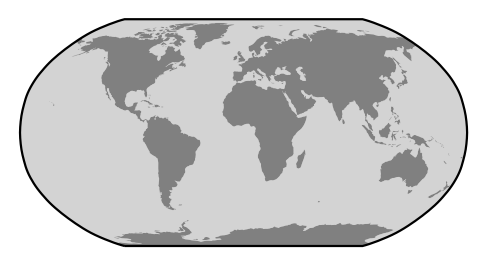

In [10]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present


    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('cooc')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes cooc [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_diff.num_pr_peaks.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes pr [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('pr')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    sc=(.25*ssp_ds_diff.num_sfcWind_peaks.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('wind')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes wind [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcWind')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''

In [ ]:
ssp_ds

AttributeError: 'Dataset' object has no attribute 'sfcWind_thresholds'

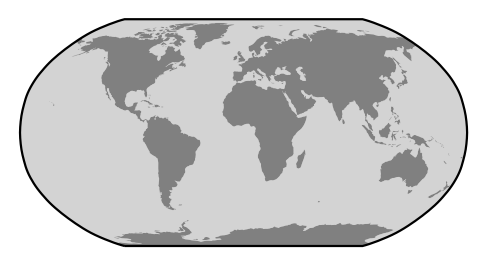

In [15]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.sfcWind_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=20,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='98% wind')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.sfcWind_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.3,vmax=.3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% Wind')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.sfcWind_thresholds.isel(quantile=8)/ssp_ds_present.sfcWind_thresholds.isel(quantile=8)).mean(dim='member_id').mean(dim='source_id').plot(cmap='seismic',vmin=-15,vmax=15,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% Wind [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcWind')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''

In [ ]:
ds_intersect

AttributeError: 'Dataset' object has no attribute 'pr_thresholds'

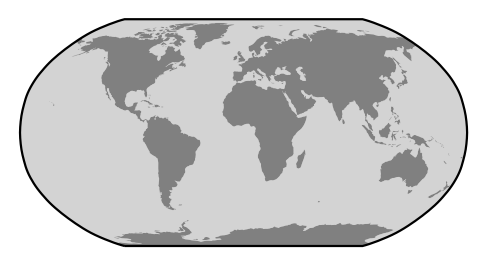

In [16]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.pr_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0.002,vmax=.010,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='98% pr')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.pr_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.002,vmax=.002,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% pr')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.pr_thresholds.isel(quantile=8)/ssp_ds_present.pr_thresholds.isel(quantile=8)).mean(dim='member_id').mean(dim='source_id').plot(cmap='seismic',vmin=-15,vmax=15,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% pr [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''


AttributeError: 'Dataset' object has no attribute 'lon'

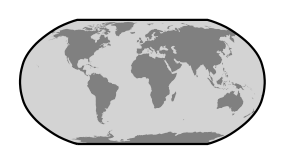

In [17]:
fig=plt.figure(figsize=(6,10)) #generate figure  
gs = fig.add_gridspec(4,3)
gs.update(wspace=.4,hspace=.1)
ssp='ssp585'    
for season in np.arange(4):
    #ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    if season ==0: #djf
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    elif season==1:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=2) + ds_intersect.sel(ssp=ssp).isel(month=3) + ds_intersect.sel(ssp=ssp).isel(month=4) 
    elif season==2:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=5) + ds_intersect.sel(ssp=ssp).isel(month=6) + ds_intersect.sel(ssp=ssp).isel(month=7) 
    elif season==3:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=8) + ds_intersect.sel(ssp=ssp).isel(month=9) + ds_intersect.sel(ssp=ssp).isel(month=10) 
    
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    ax = plt.subplot(gs[season,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('#peaks joint')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        
        
        
        
    ax = plt.subplot(gs[season,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_pr_peaks.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('#peaks pr')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        
        
    ax = plt.subplot(gs[season,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_sfcWind_peaks.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('#peaks sfcwind')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')    


In [14]:
pr_mpi = xr.open_dataset('/home/jovyan/CMIP6cf/output/pr_timeseries/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.nc').pr.sel(member_id='r1i1p1f1')

NameError: name 'pr_mpi' is not defined

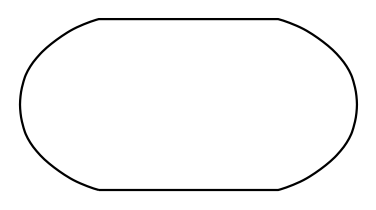

In [18]:

fig=plt.figure(figsize=(10,5)) #generate figure  
gs = fig.add_gridspec(1,4)
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>5) & (pr_mpi.time.dt.month<9))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('JJA')

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>8) & (pr_mpi.time.dt.month<12))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('SON')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>11))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('DJF')

ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>2) & (pr_mpi.time.dt.month<6))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('MAM')

AttributeError: 'Dataset' object has no attribute 'lon'

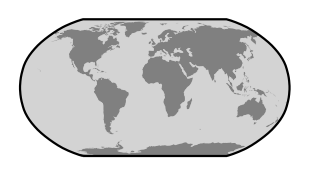

In [19]:
fig=plt.figure(figsize=(8,10)) #generate figure  
gs = fig.add_gridspec(3,4)
gs.update(wspace=.2,hspace=.1)
    
ssp='ssp585'
for m,month in enumerate(np.arange(12)):
    ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=m)

    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = (ssp_ds_future - ssp_ds_present)
    
    #1991-2020
    ax = plt.subplot(gs[np.unravel_index(m,(3,4))],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    #slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').sel(source_id='NorESM2-MM'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

   
    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
    
    ax.set_title(str(m))

  
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')

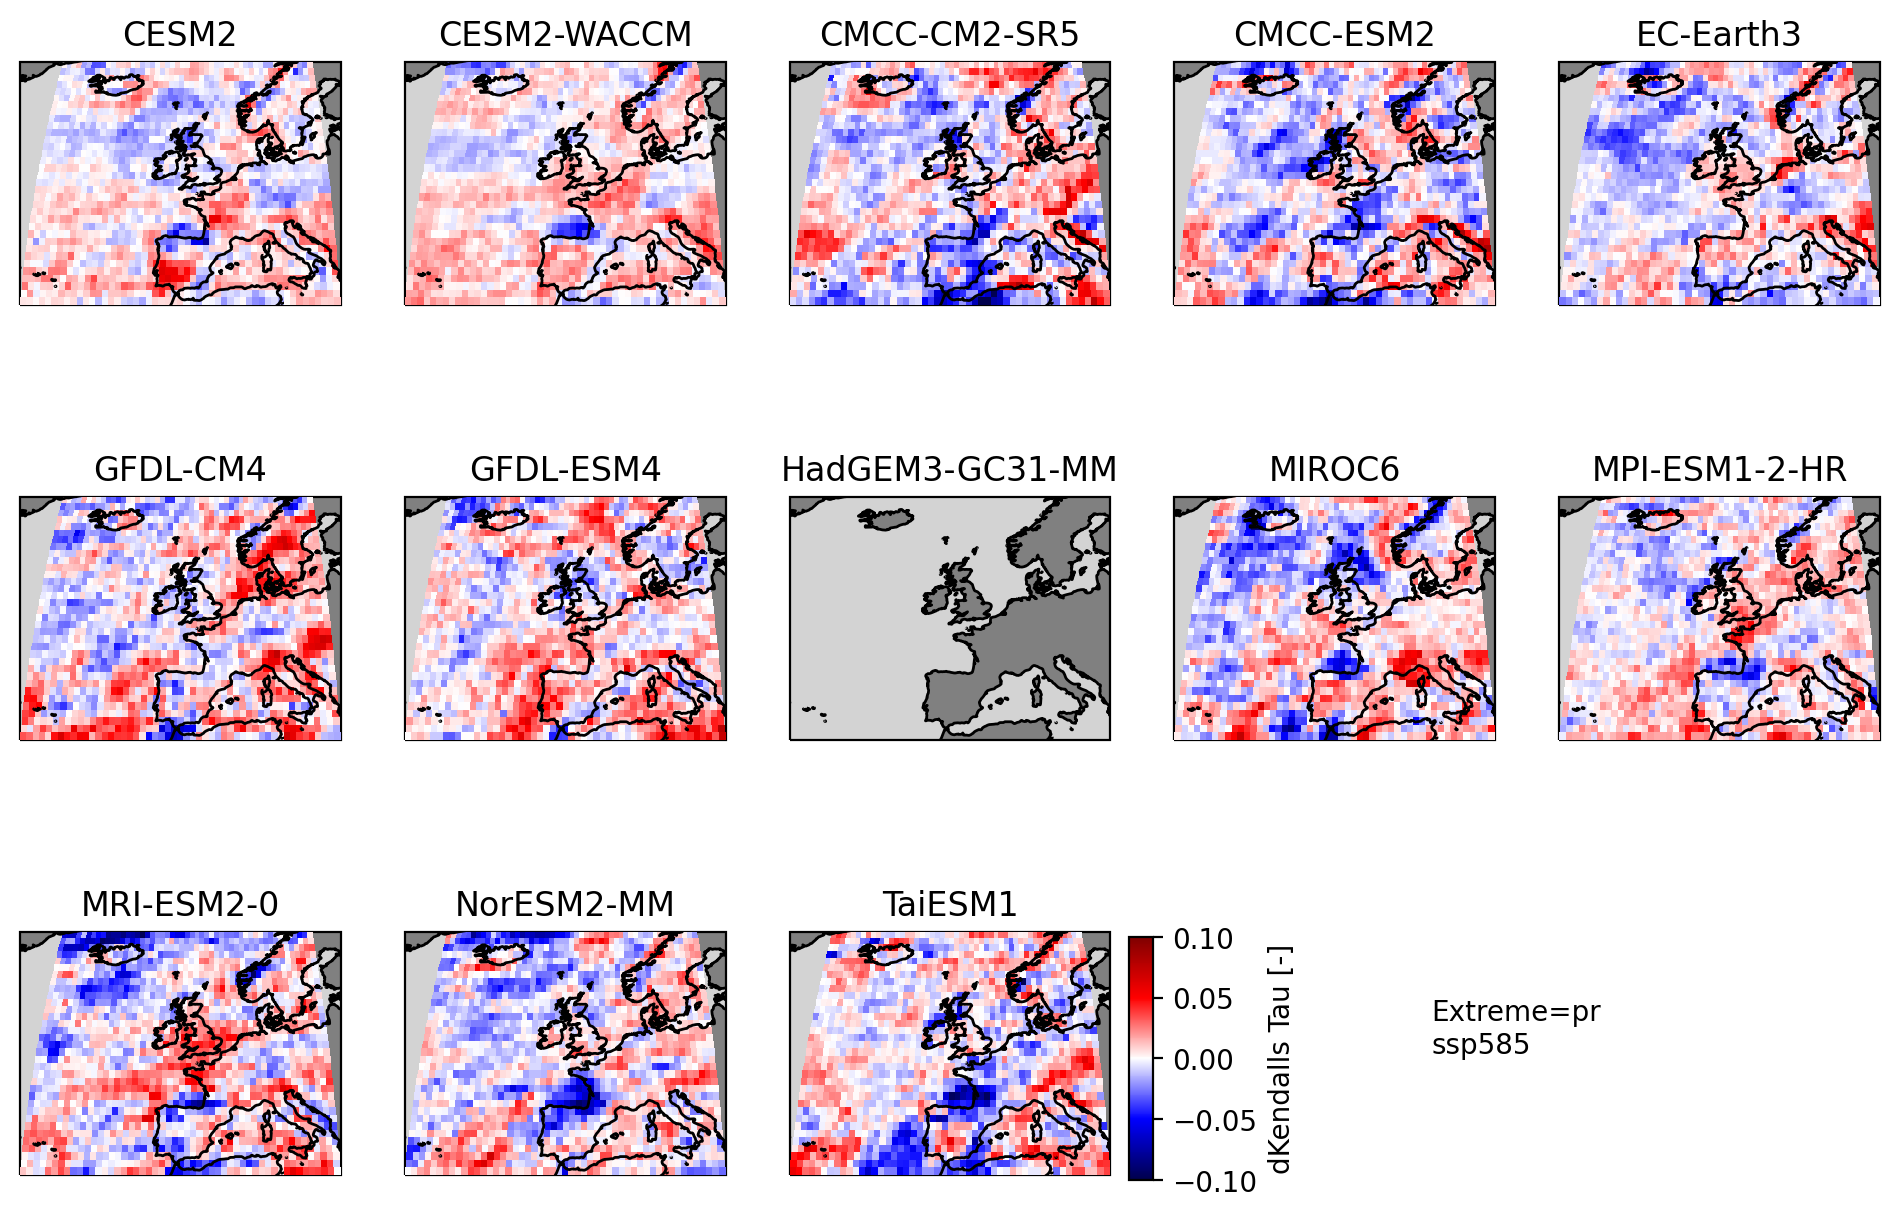

In [24]:
ssp_ds = ds_intersect.sel(ssp='ssp585').sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

fig=plt.figure(figsize=(12,8)) #generate figure  
gs = fig.add_gridspec(3,5)

for m,model in enumerate(ssp_ds.source_id.values):
    #1991-2020
    ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring.sel(source_id=model),timesteps,dim='window')*ssp_ds.num_co_occurring.sel(source_id=model).std(dim='window')/timesteps.std(dim='window')
        
    sc=(.25*slope.mean(dim='member_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
    #n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
    #ax.set_title(model +' ('+str(n_members)+')')
    ax.set_title(model)
    if m==len(ssp_ds.source_id.values)-1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dKendalls Tau [-]')
        ax.annotate('Extreme=pr\n'+ssp,(2,.5),xycoords='axes fraction')

In [20]:
ssp_ds_diff.num_co_occurring

<xarray.DataArray 'num_co_occurring' (source_id: 13, member_id: 67,
                                      latitude: 34, longitude: 51)>
array([[[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
...
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]]])
Coordinates:
  * member_id  (member_id) object 'r101i1p1f1' 'r102i1p1f1' ... 'r7i1p1f1'
  * longitude  (longitude) int64 -30 -29 -28 -27 -26 -25 ... 15 16 17 18 19 20
  * latitude   (latitude) int64 35 36 37 38 39 40 41 42 ... 62 63 64 65 66 67 68
  * source_id  (source_id) <U15 'CESM2' 'CESM2-WACCM' ... 'NorESM2-MM' 'TaiESM1'
    height     float64 10.0
    ssp        <U6 'ssp585'

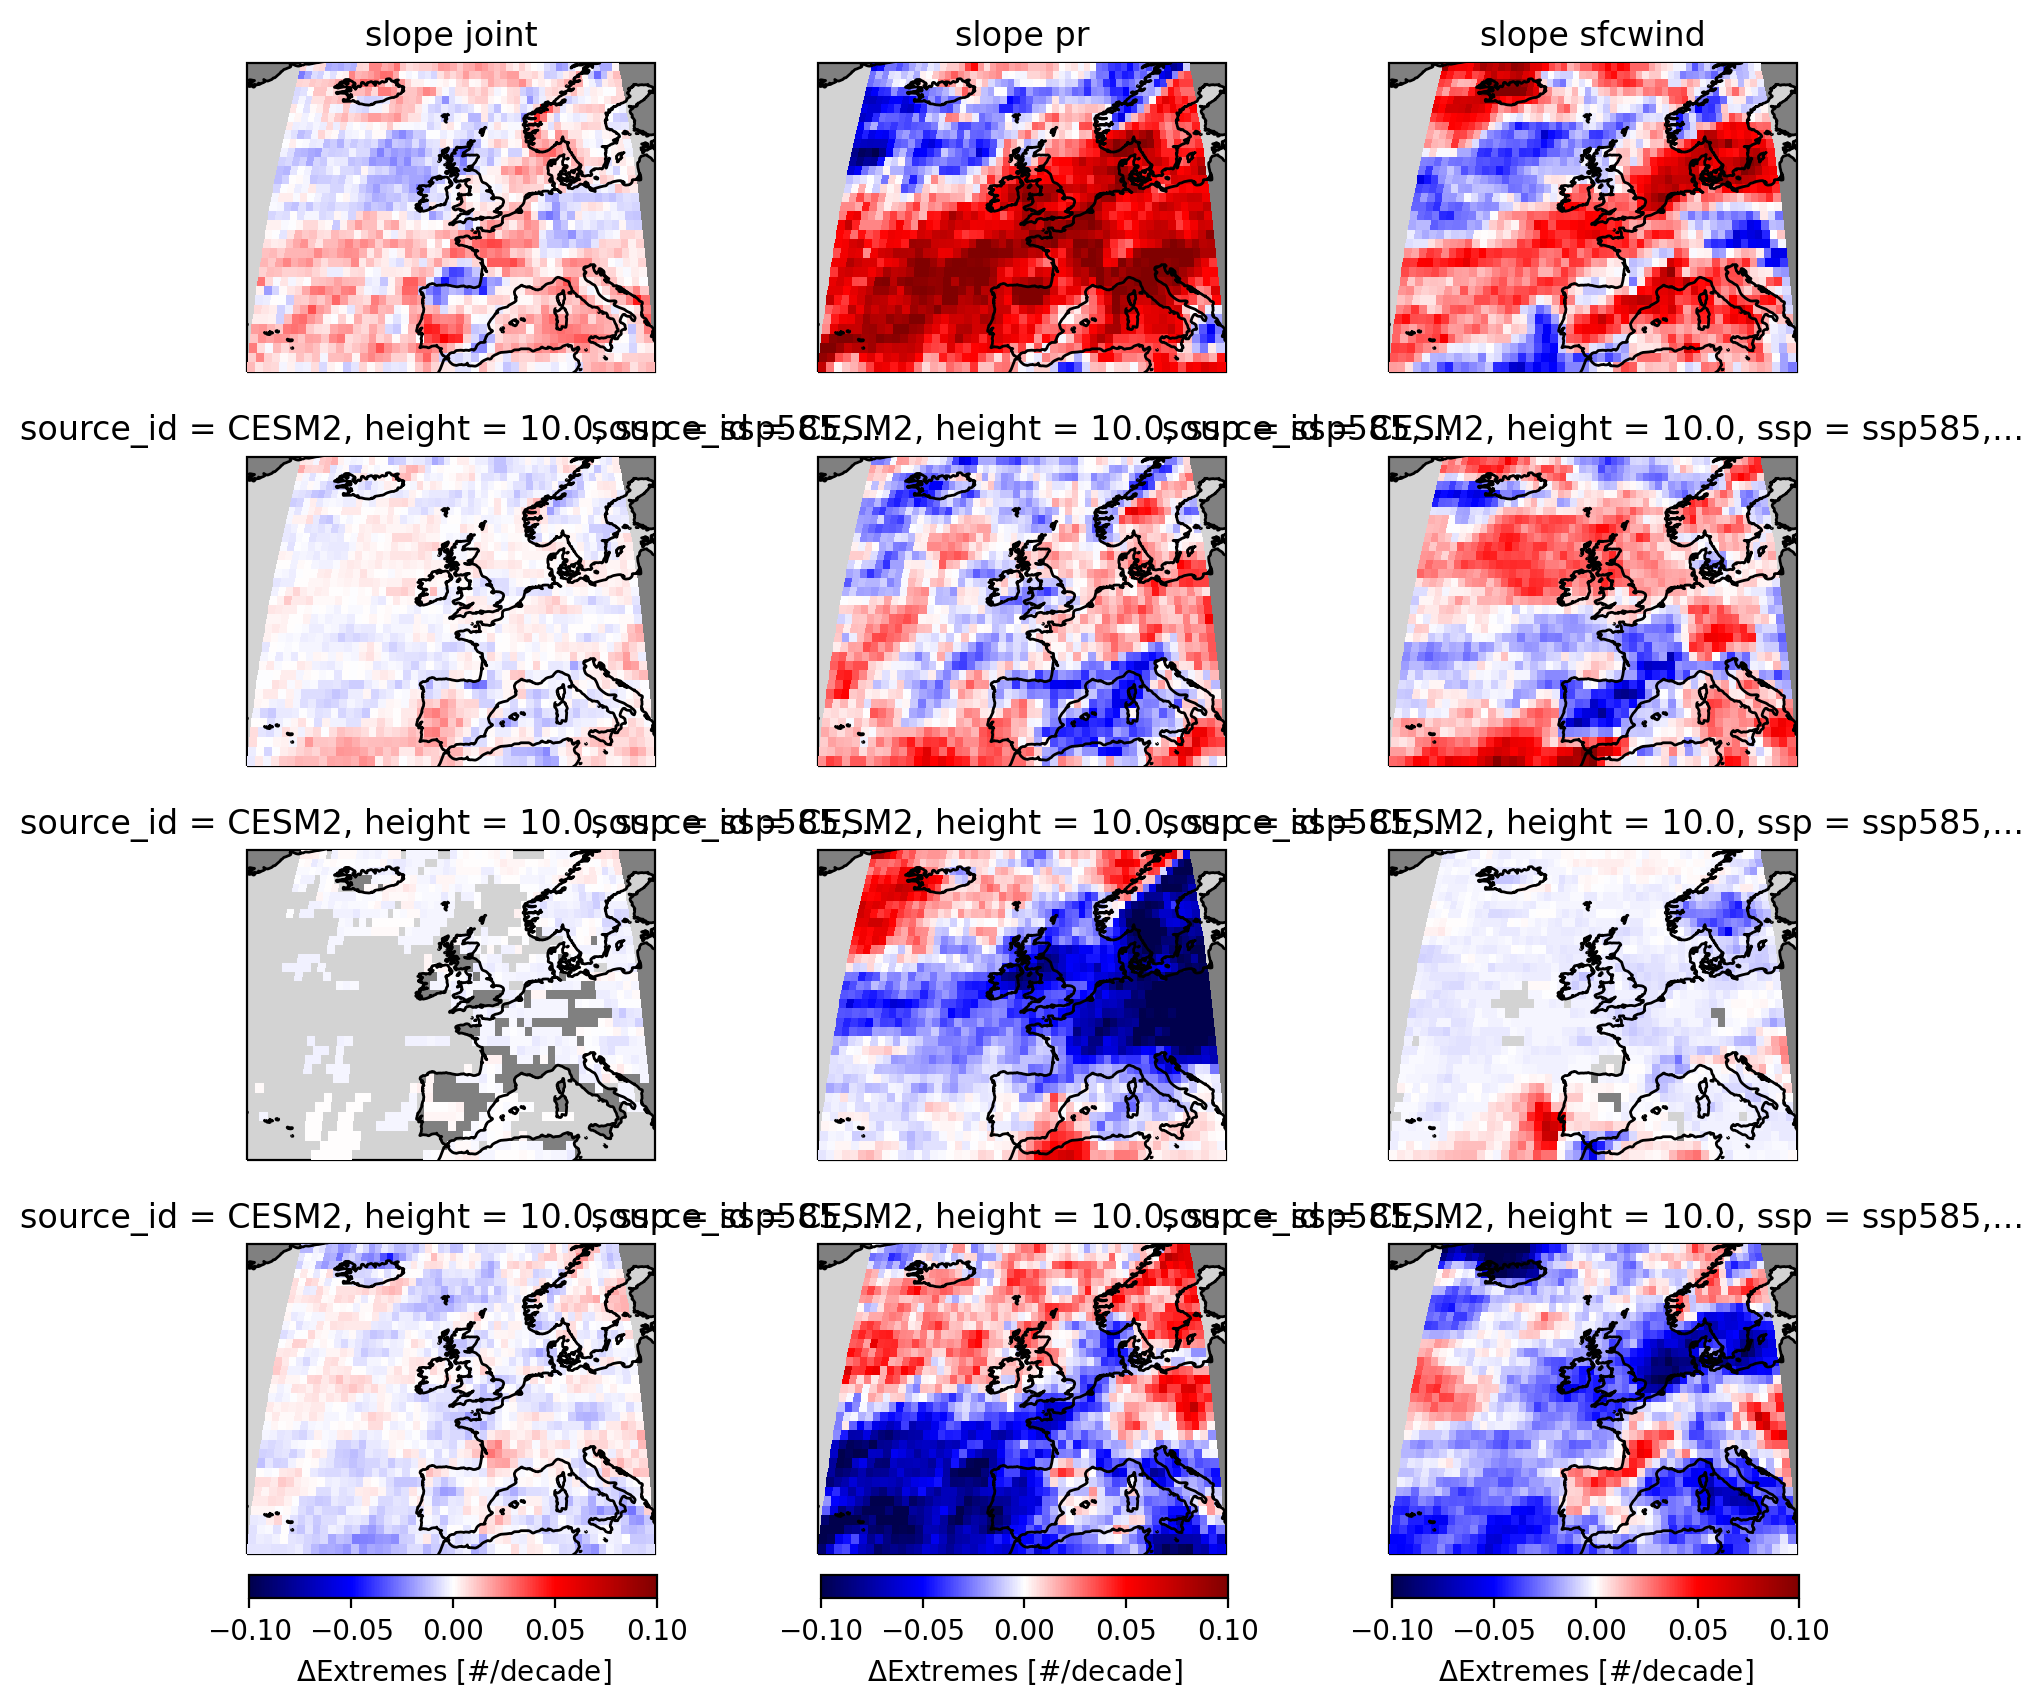

In [26]:
fig=plt.figure(figsize=(10,10)) #generate figure  
gs = fig.add_gridspec(4,3)
gs.update(wspace=.4,hspace=.1)
ssp='ssp585'    
for season in np.arange(4):
    #ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    if season ==0: #djf
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    elif season==1:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=2) + ds_intersect.sel(ssp=ssp).isel(month=3) + ds_intersect.sel(ssp=ssp).isel(month=4) 
    elif season==2:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=5) + ds_intersect.sel(ssp=ssp).isel(month=6) + ds_intersect.sel(ssp=ssp).isel(month=7) 
    elif season==3:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=8) + ds_intersect.sel(ssp=ssp).isel(month=9) + ds_intersect.sel(ssp=ssp).isel(month=10) 
    
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    ax = plt.subplot(gs[season,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree',add_colorbar=False,ax=ax)
    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
        
        
        
        
    ax = plt.subplot(gs[season,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree',add_colorbar=False,ax=ax)
    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
        
        
    ax = plt.subplot(gs[season,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree',add_colorbar=False,ax=ax)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcwind')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


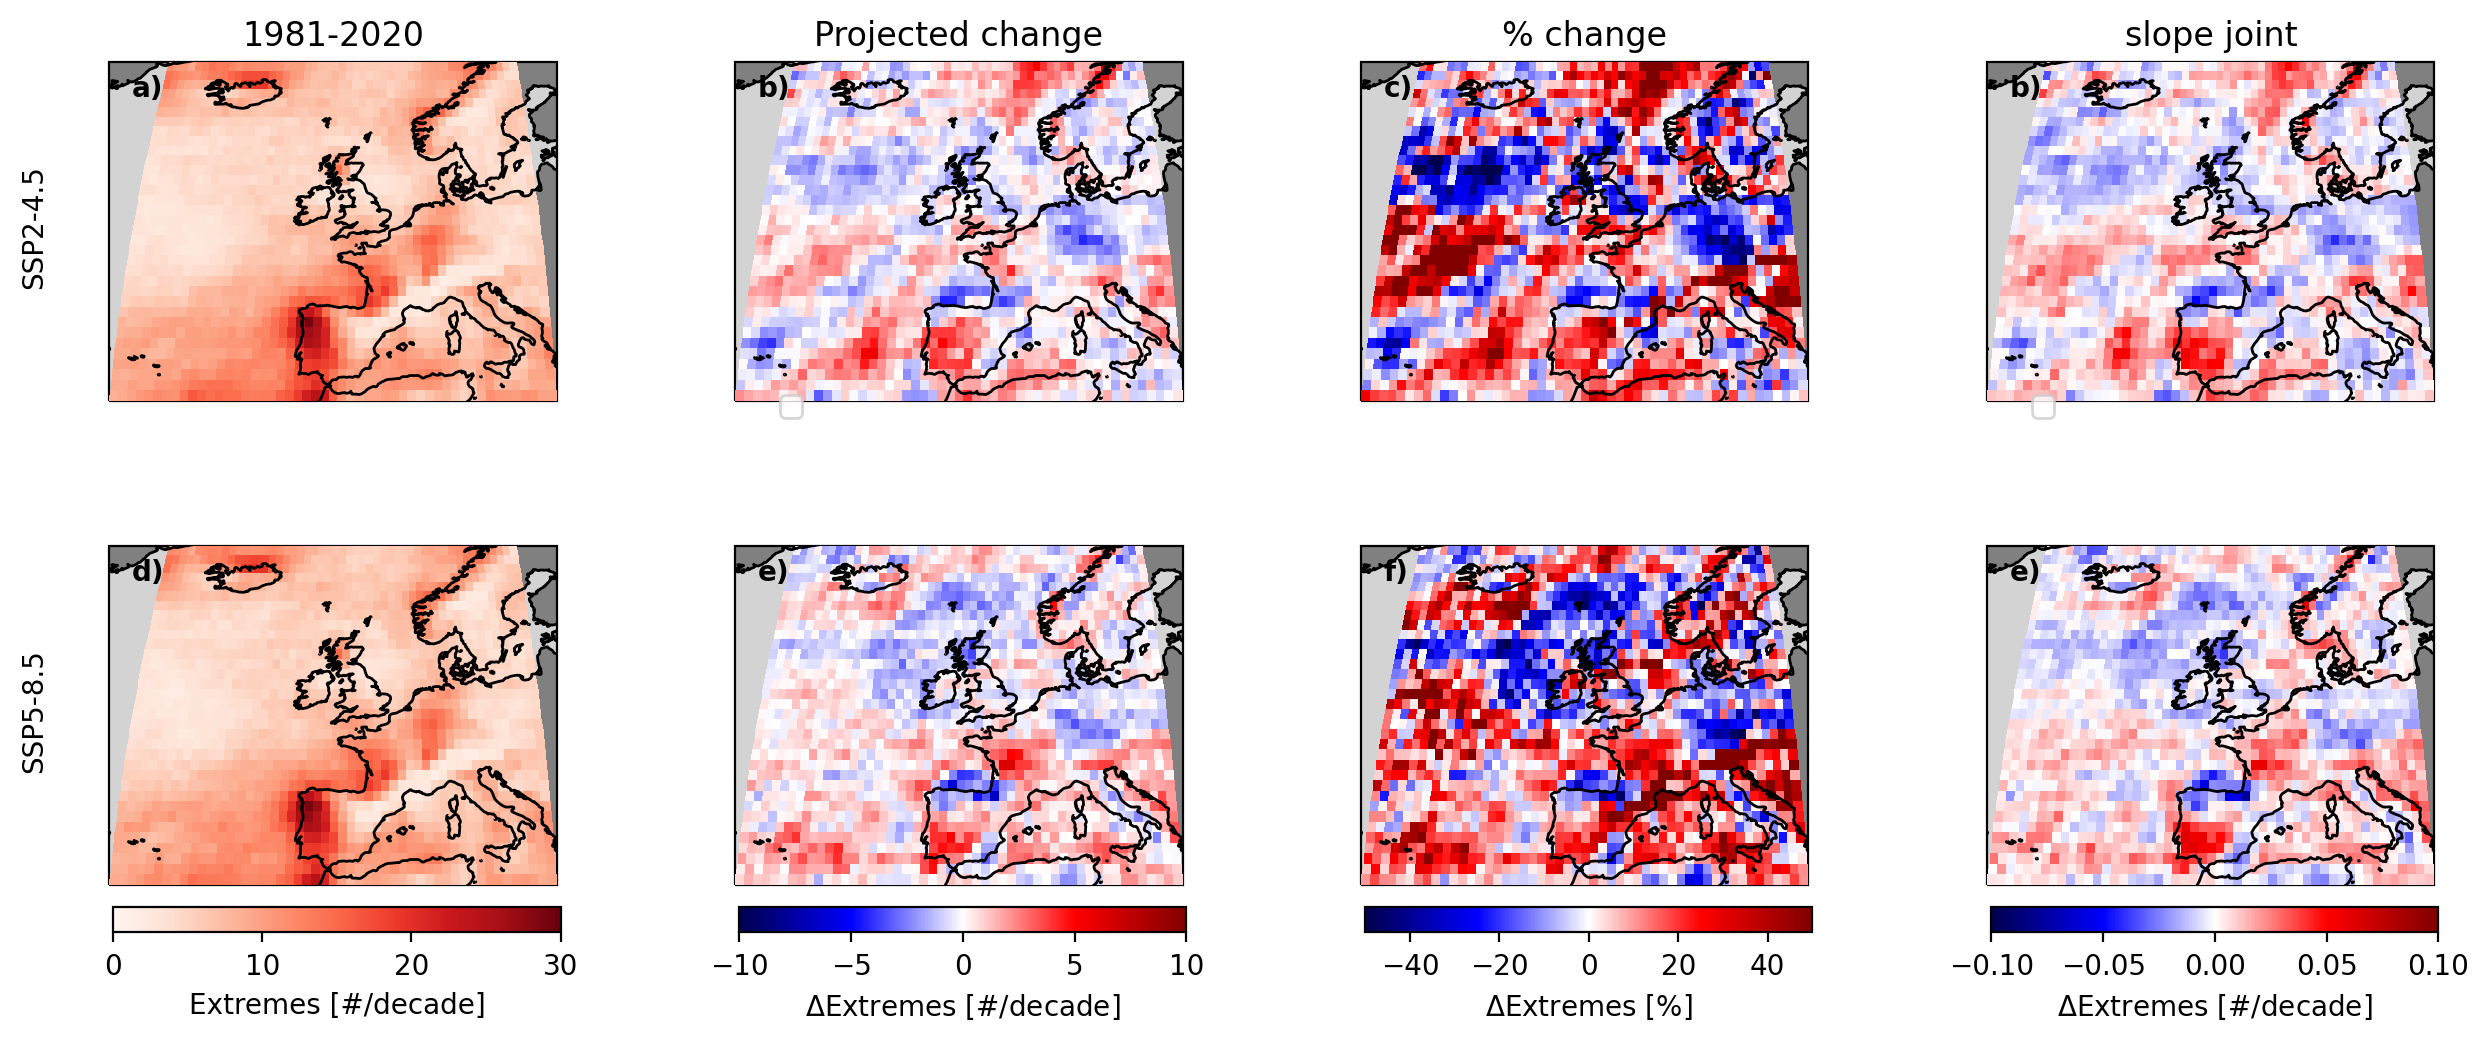

In [28]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').sel(source_id=‘CESM2’),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id='CESM2')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id=‘CESM2’)[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id=‘CESM2’)[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').sel(source_id='CESM2').plot(cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').sel(source_id=‘CESM2’),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcWind')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').sel(source_id=‘CESM2’),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''
